# An interactive Galaxy Jupyter Notebook: Plotting read coverage distribution from a BAM file

You can access your data via the dataset number. For example, ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/galaxy-ipython).

## Getting data in
After starting Jupyter session we are copying a dataset from Galaxy history space into Jupyter space. In this particular case the dataset we need have number `8` in Galaxy's history. We set `bam_file` to `8`. 

**If you want to use a different dataset as input -> replace `8` with the number of that dataset**

>`bam_file = 8`

>`get(bam_file)`

The above is not relevant here. It only applies to galaxy.

## Renaming dataset
`get` command names files using their galaxy history id. This is not a very meaningful name. So we will use UNIX commend `mv` to give this file a different name: `hiv_mapping.bam` (here `!` is used to tell Jupyter that we want to execute a shell command):

I renamed the file already :)

>`!mv {bam_file} hiv_mapping.bam`

## Configuring bioconda
The easiest way to compute the depth of sequencing coverage is with `samtools`. However, they need to be installed. In turn, the easiest way to install `samtools` is with [conda](http://conda.pydata.org/docs/) - a new generation package manager system. Here we are configuring conda's biological software channel [bioconda](https://bioconda.github.io/)

I added the bioconda channel to our environment.yml file in the top level of the repo so you don't have to add the channel manually.
>`!conda config --add channels bioconda`

## Installing `samtools`
And once conda is configures installing `samtools` is as easy as this (note the `-y` option required here):

I added the samtools to our environment.yml file in the top level of the repo so you don't have to install samtools manually.
> `!conda install -y samtools`

## Split bam file on readgroups
In this example the bam file combines mapped reads derived from three different expriments. The relationship between each read and a corresponding sample is maintained with [read group tags](https://www.broadinstitute.org/gatk/guide/article?id=6472). Since we want to compute depth of coverage for each sample separately, we first need to split the original bam file into by read groups. This is done using `samtools split` command:

## Start here!

In [43]:
!samtools split hiv_mapping.bam

You can also
```
import pysam
pysam.split("hiv_mapping.bam")
```

Listing files will show three newly generated datasetes called hiv_mapping_0, _1, and _2:

In [19]:
!ls hiv*

hiv_mapping.bam   hiv_mapping_0.bam hiv_mapping_1.bam hiv_mapping_2.bam


## Computing coverage
We compute coverage using `samtools depth` command. Note how Python's `for` loop is used here. It iterates over three numbers (0, 1, and 2) generated by the `range` function. There are substituted into file names. This way we generate three coverage files (one for each read group) in one go. 

Of particular importance is the use of `-a` option when we compute depth. Because of this flag `samtools depth` outputs depth at every position even is the coverage at that position is 0. This woild allow us to paste the three datasets side by side making sure that every row described the same position of the reference genome. 

**If your dataset has a different number of read groups -> replace `3` within the `range()` function with that number**

In [32]:
for item in range(3):
    !samtools depth -a hiv_mapping_{item}.bam > readgroup_{item}.cvrg

Listing files shows three additional datasets (ending with `cvrg` that we have just generated):

In [33]:
!ls *.cvrg*

readgroup_0.cvrg readgroup_1.cvrg readgroup_2.cvrg


Now we can paste these three files side by side removing duplicate columns using UNIX `cut` command:

In [34]:
!paste readgroup_* | cut -f 1,2,3,6,9 > all_cvrg.txt

This new datasets called `all_cvrg.txt` contains five columns (see outputs of `head` and `tail` commands below): 

 - Reference genome name
 - Position in the genome
 - Coverage in sample A
 - Coverage in sample B
 - Coverage in sample C

In [35]:
!head -n 4 all_cvrg.txt

O1BFS1860	1	3581	3577	3642
O1BFS1860	2	3681	3702	3781
O1BFS1860	3	3694	3716	3789
O1BFS1860	4	3711	3735	3823


In [36]:
!tail -n 4 all_cvrg.txt

O1BFS1860	8159	3486	3524	3585
O1BFS1860	8160	3454	3495	3543
O1BFS1860	8161	3410	3456	3493
O1BFS1860	8162	3383	3428	3476


## Plotting coverage across the HIV genome

Let's import `pandas` a data manipulation library that allows datasets to be handled in an R-like way: 

In [37]:
import pandas as pd

We will then import the `all_cvrg.txt` dataset as Pandas dataframe:

In [38]:
data = pd.read_table('all_cvrg.txt',header=None)

Set column names

In [39]:
data.columns=["Ref","pos","sample A","sample B","sample C"]

And take a look at the result

In [40]:
data.head()

,Ref,pos,sample A,sample B,sample C
0,O1BFS1860,1,3581,3577,3642
1,O1BFS1860,2,3681,3702,3781
2,O1BFS1860,3,3694,3716,3789
3,O1BFS1860,4,3711,3735,3823
4,O1BFS1860,5,3717,3745,3838


Next we will import [matplotlib](http://matplotlib.org/) - a graphing library:

In [41]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

and simply plot the data

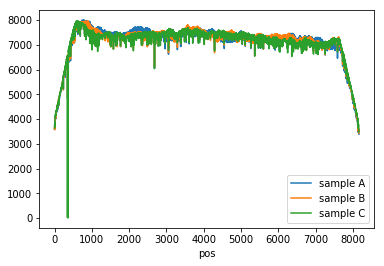

In [42]:
data.plot(x="pos")

You can see that coverage a fairly even across the three samples peaking at around 8,000x